In [7]:
import pandas as pd

# تحميل البيانات باستخدام المسار الكامل
df = pd.read_csv(r"C:\Users\asus\Desktop\crime-prediction-project2\data\Crimes_-_2025_20250416.csv")

# عرض أول 5 صفوف للتأكد من نجاح التحميل
print(df.head())


         ID Case Number                    Date                  Block  IUCR  \
0  13798157    JJ208794  04/07/2025 12:00:00 AM  045XX S FAIRFIELD AVE  1310   
1  13799362    JJ209126  04/07/2025 12:00:00 AM        004XX E 35TH ST  0460   
2  13802625    JJ214096  04/07/2025 12:00:00 AM    0000X N FRANKLIN ST  1130   
3  13798228    JJ208907  04/07/2025 12:00:00 AM      048XX S ELLIS AVE  0910   
4  13798819    JJ209431  04/07/2025 12:00:00 AM      005XX W CERMAK RD  1206   

          Primary Type                     Description Location Description  \
0      CRIMINAL DAMAGE                     TO PROPERTY            RESIDENCE   
1              BATTERY                          SIMPLE         CTA BUS STOP   
2   DECEPTIVE PRACTICE        FRAUD OR CONFIDENCE GAME        HOTEL / MOTEL   
3  MOTOR VEHICLE THEFT                      AUTOMOBILE               STREET   
4   DECEPTIVE PRACTICE  THEFT BY LESSEE, MOTOR VEHICLE   SMALL RETAIL STORE   

   Arrest  Domestic  ...  Ward  Community Ar

In [11]:
!pip install statsmodels


  Using cached statsmodels-0.14.4-cp311-cp311-win_amd64.whl.metadata (9.5 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp311-cp311-win_amd64.whl (9.9 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from statsmodels.tsa.seasonal import seasonal_decompose

# قراءة الملف
df = pd.read_csv(r"C:\Users\asus\Desktop\crime-prediction-project2\data\Crimes_-_2025_20250416.csv")

# معالجة التاريخ والمواقع
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')
df = df.dropna(subset=['Latitude', 'Longitude', 'Date'])


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN


In [16]:
# أخذ عينة عشوائية من 5000 سجل لتقليل استهلاك الذاكرة
df_sample = df.sample(n=5000, random_state=42)


In [18]:
coords = df_sample[['Latitude', 'Longitude']].values
coords_rad = np.radians(coords)


In [19]:
# استخدام وحدة المسافات الجغرافية 'haversine'
db = DBSCAN(eps=0.01, min_samples=50, metric='haversine')
db.fit(coords_rad)

# إضافة نتائج التجميع إلى البيانات
df_sample['Cluster'] = db.labels_


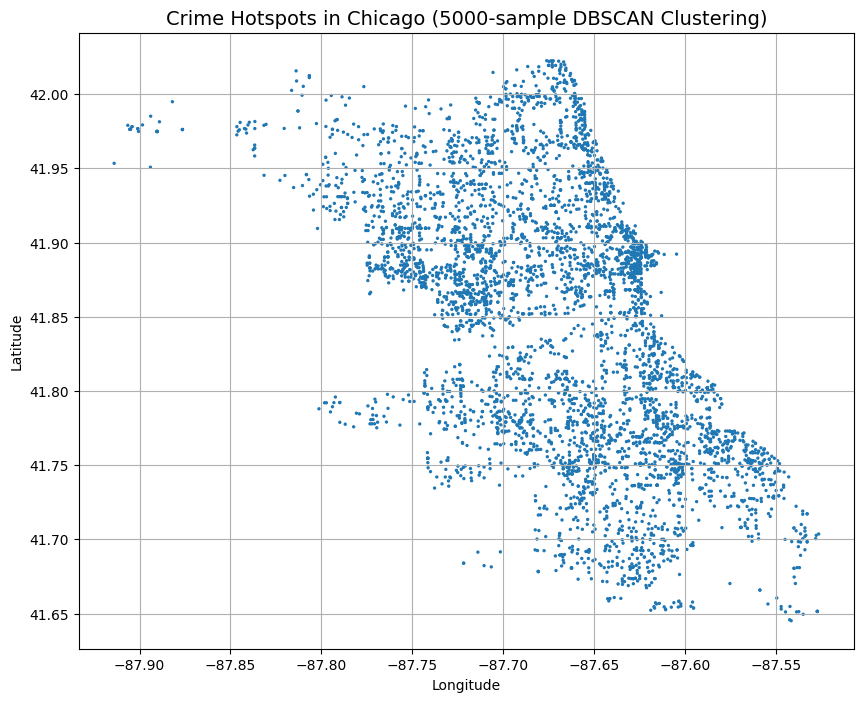

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(df_sample['Longitude'], df_sample['Latitude'], c=df_sample['Cluster'], cmap='tab20', s=2)
plt.title("Crime Hotspots in Chicago (5000-sample DBSCAN Clustering)", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [22]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')
df = df.dropna(subset=['Date'])
df.set_index('Date', inplace=True)


In [23]:
daily_counts = df.resample('D').size().to_frame(name='y')


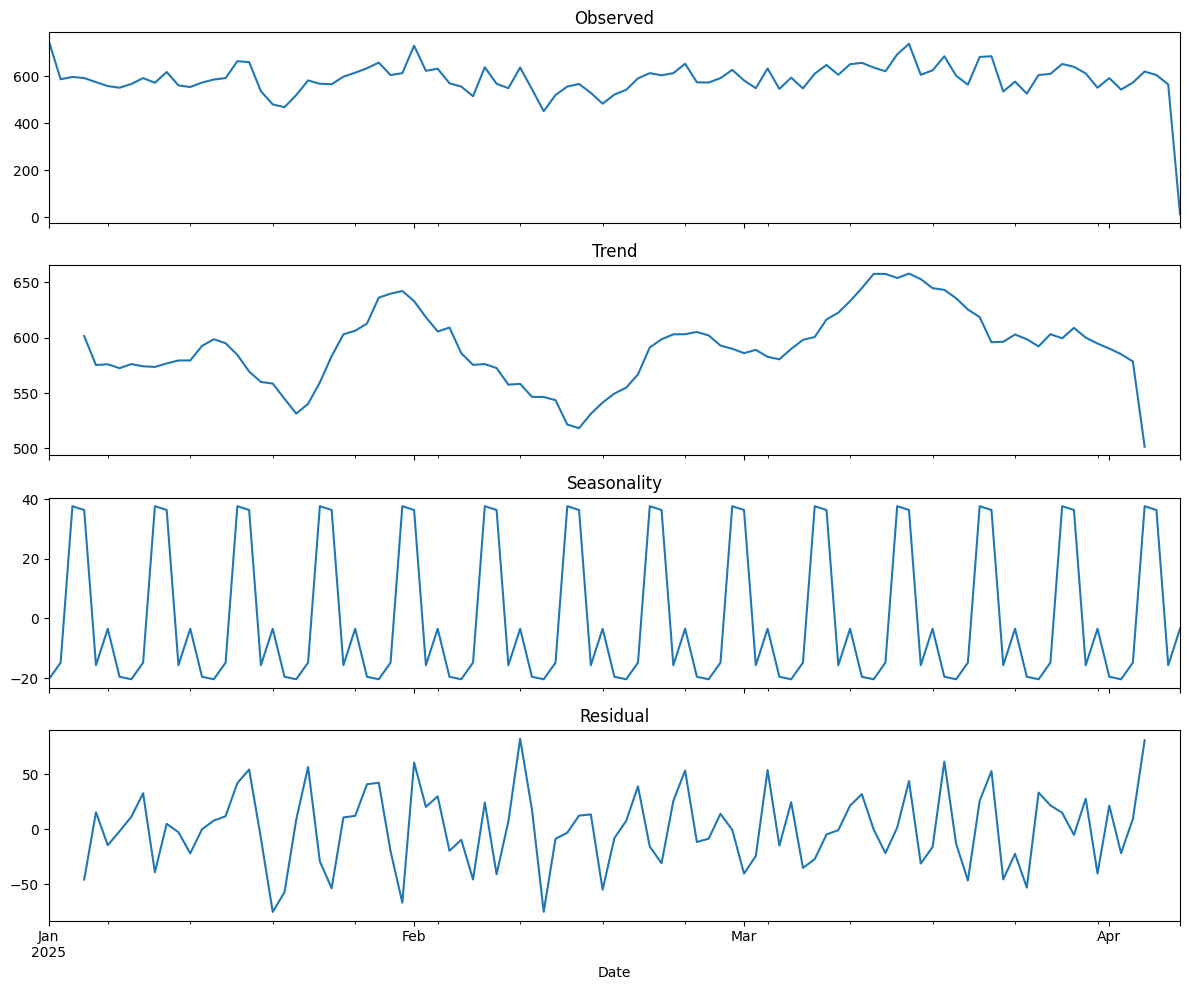

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_counts['y'], model='additive', period=7)

# عرض النتائج
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=ax[0], title='Observed')
decomposition.trend.plot(ax=ax[1], title='Trend')
decomposition.seasonal.plot(ax=ax[2], title='Seasonality')
decomposition.resid.plot(ax=ax[3], title='Residual')
plt.tight_layout()
plt.show()


In [29]:
# التأكد أن عمود Arrest من النوع الرقمي (0 أو 1)
df['Arrest'] = df['Arrest'].astype(int)

# إنشاء خصائص زمنية
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek

# اختيار المتغيرات المستقلة والهدف
X = df[['Hour', 'DayOfWeek']]
y = df['Arrest']


In [30]:
# تقسيم البيانات إلى تدريب واختبار
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [33]:
#تدريب نموذج Random Forest
from sklearn.ensemble import RandomForestClassifier

# تدريب النموذج مع class_weight='balanced'
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', random_state=42)

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.55      0.66     13990
           1       0.20      0.52      0.29      3095

    accuracy                           0.54     17085
   macro avg       0.52      0.53      0.48     17085
weighted avg       0.72      0.54      0.59     17085



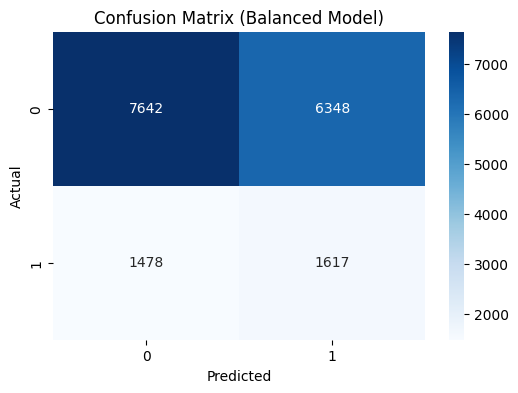

In [34]:
#التقييم وعرض النتائج
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# التنبؤ بالبيانات
y_pred = model.predict(X_test)

# عرض التقرير
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# عرض مصفوفة الالتباس
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Balanced Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

